--PART1--


In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/AAX/Seminar2'
skelleton_df = pd.read_csv(data_path + "/Train_skelletonpoints.csv", delimiter=",", header=None)
print(skelleton_df.size)
features_df = pd.read_csv(data_path + "/Train_features.csv", delimiter=",", header=None)
print(features_df.size)
labels_df = pd.read_csv(data_path + "/Train_labels.csv", delimiter=",", header=None)
print(labels_df.size)
print(skelleton_df.head())
print(features_df.head())
print(labels_df)

Mounted at /content/drive
54000
270000
1000
       0       1       2       3       4       5       6       7       8   \
0  136.03  198.72  194.99  241.76  201.30  202.46  278.33  351.28  351.28   
1  202.42  259.99  255.88  313.45  297.00  264.10  317.56  387.46  383.35   
2  193.42  250.56  254.64  340.35  397.49  246.48  319.94  270.97  401.57   
3  205.81  257.79  255.71  301.45  268.18  259.87  313.92  388.78  380.46   
4  289.49  303.86  300.27  354.16  415.24  307.46  354.16  404.46  364.94   

       9   ...       44       45       46       47       48       49       50  \
0  458.27  ...  0.68862  0.78250  0.68072  0.62456  0.68884  0.77941  0.83174   
1  473.81  ...  0.60709  0.82400  0.75419  0.65880  0.80821  0.77518  0.86345   
2  479.12  ...  0.31261  0.57599  0.68195  0.25706  0.27761  0.26193  0.95407   
3  471.95  ...  0.75569  0.89123  0.70243  0.65057  0.72541  0.75135  0.78706   
4  451.17  ...  0.43415  0.59738  0.66353  0.51422  0.79301  0.73571  0.67160   

      

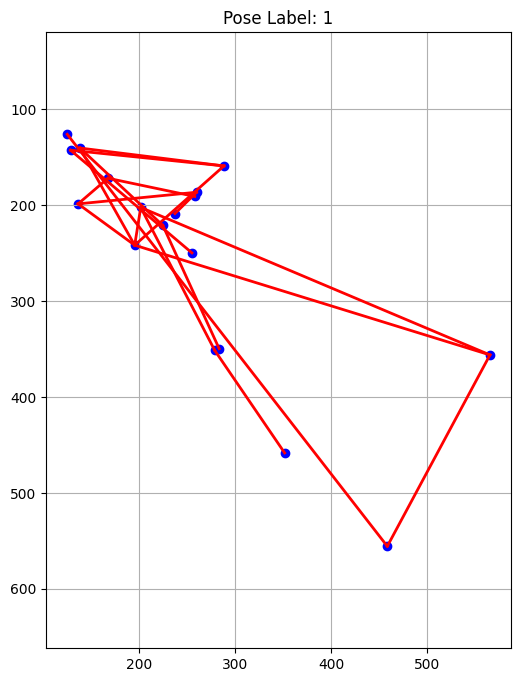

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Define edges (adjusted to 0-based indexing for Python)
SKELETON_EDGES_18 = [
    (0, 1),
    (1, 2),
    (2, 3),
    (3, 4),
    (1, 5),
    (5, 6),
    (6, 7),
    (1, 8),
    (8, 9),
    (9, 10),
    (1, 11),
    (11, 12),
    (12, 13),
    (0, 14),
    (0, 15),
    (14, 16),
    (15, 17),
    (2, 5),
    (8, 11)
]

# Plotting function
def plot_pose(keypoints, label=None):

    x = keypoints[::2]
    y = keypoints[1::2]

    plt.figure(figsize=(6, 8))
    plt.scatter(x, y, color='blue')

    for i, j in SKELETON_EDGES_18:
        if i < len(x) and j < len(x):
            plt.plot([x[i], x[j]], [y[i], y[j]], 'r-', linewidth=2)

    if label is not None:
        plt.title(f'Pose Label: {label}')
    else:
        plt.title('Pose Skeleton')

    plt.gca().invert_yaxis()  # Optional: Flip Y to match image coordinate system
    plt.axis('equal')
    plt.grid(True)
    plt.show()



# Pick sample 0
sample_keypoints = skelleton_df.iloc[0].values[:36]  # 18 (x, y) pairs = 36 values
label = labels_df.iloc[0, 0]

plot_pose(sample_keypoints, label)


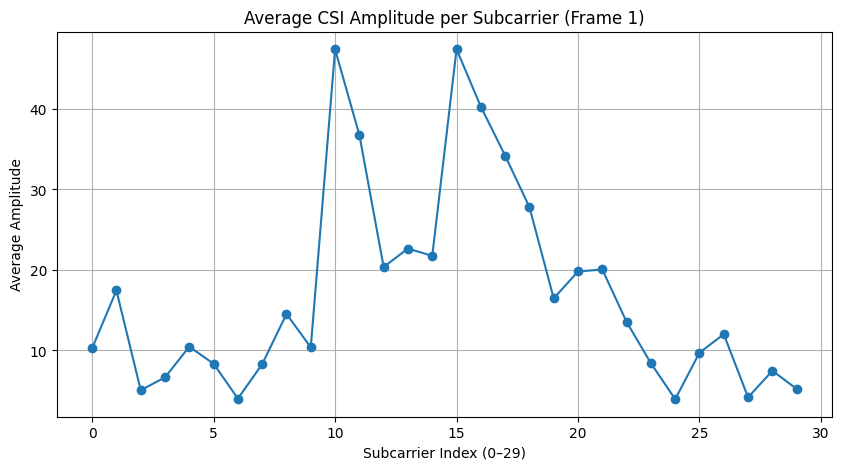

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n_subcarriers = 30   #Number of Subcarriers
n_tx = 3             #Number of antenas
n_rx = 3             #Number of Wifi-trasmitters
n_antennas = n_tx * n_rx  # Number of antennas pairs


csi_data = features_df.values

def plot_average_csi(frame_index):
    """
    Plot the average CSI amplitude per subcarrier for a specific CSI frame.
    """
    frame = csi_data[frame_index]  # shape: (270,)
    frame_matrix = frame.reshape(n_subcarriers, n_antennas)  # shape: (30, 9)

    avg_amplitude = frame_matrix.mean(axis=1)  # average over 9 antenna pairs

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(n_subcarriers), avg_amplitude, marker='o')
    plt.title(f'Average CSI Amplitude per Subcarrier (Frame {frame_index})')
    plt.xlabel('Subcarrier Index (0–29)')
    plt.ylabel('Average Amplitude')
    plt.grid(True)
    plt.show()


plot_average_csi(1)

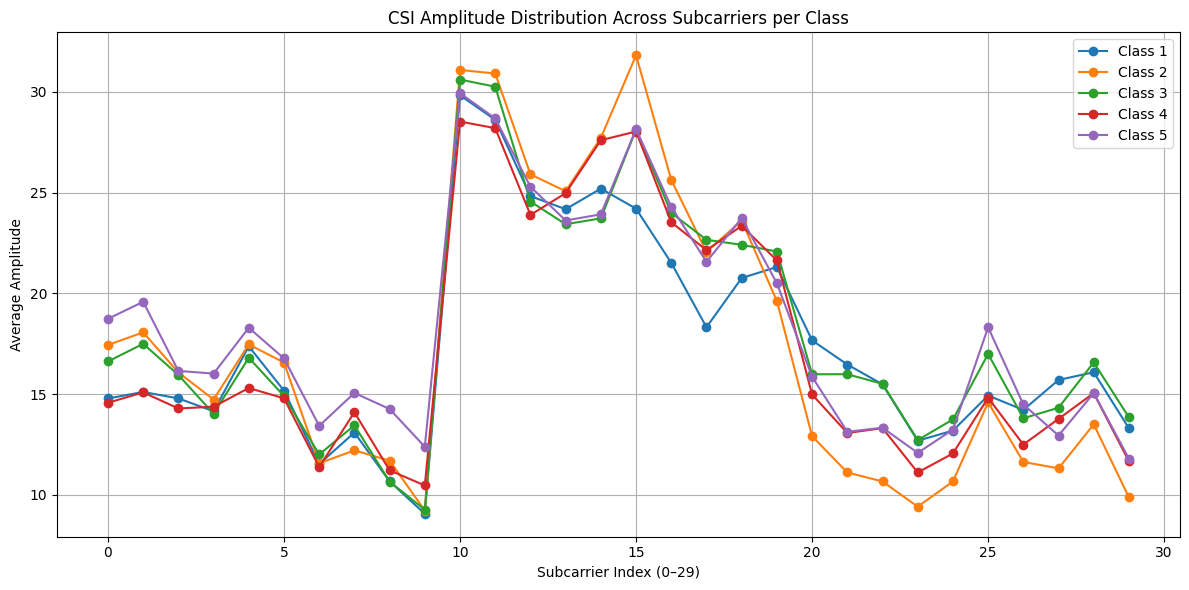

In [4]:

#There are only 5 classes because there are only 5 yoga posses


csi_data = features_df.values  # shape: (n_samples, 270)
labels = labels_df.values.flatten()  # shape: (n_samples,)

# Group by class and compute average per subcarrier
unique_labels = np.unique(labels)

plt.figure(figsize=(12, 6))

for class_label in unique_labels:
    # Get samples of the current class
    class_indices = np.where(labels == class_label)[0]
    class_csi = csi_data[class_indices]  # shape: (n_class_samples, 270)

    # Reshape and average over antenna pairs
    reshaped = class_csi.reshape(-1, n_subcarriers, n_antennas)  # shape: (n_class_samples, 30, 9)
    avg_amplitude = reshaped.mean(axis=2).mean(axis=0)  # mean over samples and antennas → (30,)

    # Plot
    plt.plot(range(n_subcarriers), avg_amplitude, marker='o', label=f'Class {class_label}')

plt.title('CSI Amplitude Distribution Across Subcarriers per Class')
plt.xlabel('Subcarrier Index (0–29)')
plt.ylabel('Average Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


//PART2//

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

class WiFiPoseClassifier:
    def __init__(self, kernel='rbf', C=1.0, gamma='scale'):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.model = None
        self.label_encoder = LabelEncoder()

    def load_data(self, X, y_raw):

        y_raw = y_raw.to_numpy().flatten().astype(str)  # Convert to NumPy, flatten, and clean
        self.label_encoder.fit(y_raw)
        self.X = X
        self.y = self.label_encoder.transform(y_raw)

    def train(self, test_size=0.2, random_state=42):
      X_train, X_test, y_train, y_test = train_test_split(
          self.X, self.y, test_size=test_size, random_state=random_state
      )
      self.model = SVC(kernel=self.kernel, C=self.C, gamma=self.gamma)
      self.model.fit(X_train, y_train)
      return X_test, y_test


    def predict(self, sample):
        """
        Predict pose for a single sample (1D feature vector).
        """
        if self.model is None:
            raise ValueError("Model is not trained.")
        pred = self.model.predict([sample])
        return self.label_encoder.inverse_transform(pred)[0]

    def evaluate(self, X_test, y_test):
      y_pred = self.model.predict(X_test)
      class_names = self.label_encoder.inverse_transform(np.unique(y_test))

      print("Accuracy:", accuracy_score(y_test, y_pred))
      print("Classification Report:\n",
            classification_report(y_test, y_pred, target_names=class_names))
      return y_pred



In [24]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load data
data_path = '/content/drive/MyDrive/AAX/Seminar2'
train_features = pd.read_csv(data_path + "/Train_features.csv", delimiter=",", header=None)
train_labels = pd.read_csv(data_path + "/Train_labels.csv", delimiter=",", header=None)
test_features = pd.read_csv(data_path + "/Test_features.csv", delimiter=",", header=None)
test_labels = pd.read_csv(data_path + "/Test_labels.csv", delimiter=",", header=None)

# Prepare data
X_train = train_features.values
X_test = test_features.values
y_train = train_labels.values.T.ravel()
y_test = test_labels.values.T.ravel()

# 1. Feature Scaling (try different scalers)
scaler = StandardScaler()  # Also try MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Handle Class Imbalance (if exists)
print("Class distribution:", np.unique(y_train, return_counts=True))
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# 3. Feature Selection
selector = SelectKBest(f_classif, k=100)  # Select top 100 features
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test_scaled)

# 4. Dimensionality Reduction (alternative to feature selection)
pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Reduced to {pca.n_components_} components")

# 5. Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': [None, 'balanced']
}

# Using either the selected features or PCA-reduced features
X_tuning = X_train_selected  # or X_train_pca
y_tuning = y_train_balanced

grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_tuning, y_tuning)

# Get best model
best_svm = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

# 6. Final Evaluation
test_preds = best_svm.predict(selector.transform(X_test_scaled))  # or pca.transform(X_test_scaled)

print("\nTest Performance:")
print(f"Accuracy: {accuracy_score(y_test, test_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, test_preds))

# 7. Feature Importance Analysis (for linear kernel)
if best_svm.kernel == 'linear':
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(best_svm.coef_[0])), best_svm.coef_[0])
    plt.title("Feature Importance (Linear SVM)")
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class distribution: (array([1, 2, 3, 4, 5]), array([169, 210, 174, 226, 221]))
Reduced to 33 components
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.8885

Test Performance:
Accuracy: 0.8500

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.86      0.88        42
           2       0.77      0.87      0.82        39
           3       0.84      0.77      0.81        35
           4       0.89      0.82      0.85        38
           5       0.86      0.91      0.88        46

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200

